In [44]:
# !pip install mplsoccer
# !pip install statsbombpy

In [45]:
from mplsoccer.pitch import Pitch
import matplotlib.patches as patches
import matplotlib.pyplot as plt
from statsbombpy import sb
import pandas as pd
import warnings
from pandas.errors import SettingWithCopyWarning
from statsbombpy.api_client import NoAuthWarning

warnings.simplefilter(action='ignore', category=SettingWithCopyWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=NoAuthWarning)

In [46]:
# ATTRIBUTES_LIST = ["Pass","Shot","Dribble"]
ATTRIBUTES_LIST = ["Pass","Shot","Dribble"]

<br><br><br><br>
### Jupyter - loading_bar_html

In [47]:
from IPython.display import display, HTML
loading_bar_html = """
<div id="progress-container" style="width: 50%; border: 1px solid #ccc; margin: 20px 0;">
  <div id="progress-bar" style="width: 0%; height: 20px; background-color: #4CAF50; text-align: center; line-height: 20px; color: white;"></div>
</div>
<script>
function updateProgressBar(progress) {
  var progressBar = document.getElementById('progress-bar');
  progressBar.style.width = progress + '%';
  progressBar.innerHTML = progress + '%';
}
</script>
"""

In [54]:
# competition_id = 9
# season_id = 281
# all_events = []
# matches = sb.matches(competition_id=competition_id, season_id=season_id)
# matches_ids = matches["match_id"] #[3895074] #matches["match_id"]
# match_number = len(matches_ids)

# display(HTML(loading_bar_html)) # loading_bar_html
# for process, match_id in enumerate(matches_ids):
#     events = sb.events(match_id=match_id)
#     all_events.append(events) 
#     progress = int((process + 1) / match_number * 100) # loading_bar_html
#     display(HTML("<script>updateProgressBar({})</script>".format(progress))) # loading_bar_html
# print("__completed__!")
# master_events_df = pd.concat(all_events, ignore_index=True)

In [126]:
master_events_df = pd.read_csv("data/Bayer Leverkusen Bundesliga 23-24 Statsbomb Events Data.csv", low_memory=False)

<img src="https://i.ibb.co/54hgbWX/image.png">
<!-- events_df[events_df['type'] == "Shot"][["player","location","shot_statsbomb_xg","timestamp"]] -->

In [6]:
file_title = "leverkusen_2024" + "_"
pitch_color = "red"

Pass is completed! ➡️
Shot is completed! ➡️
Dribble is completed! ➡️


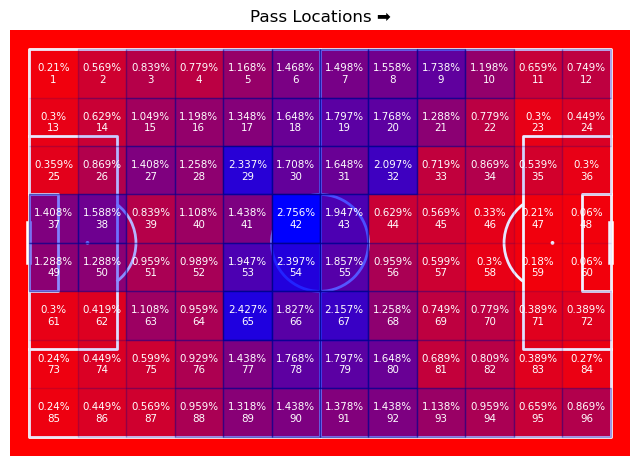

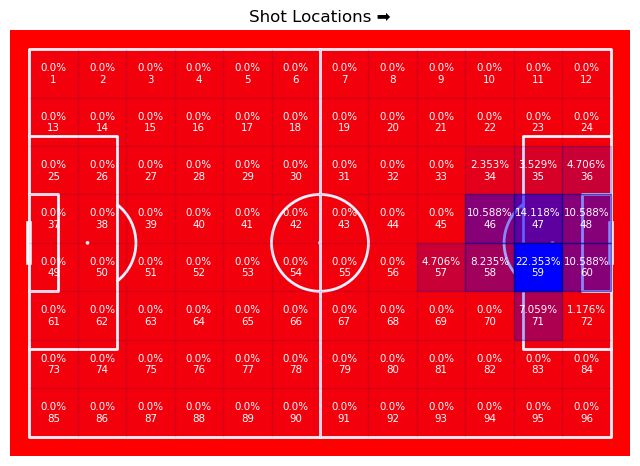

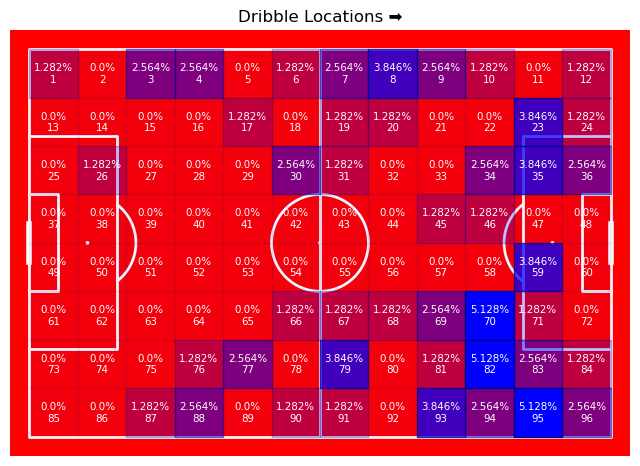

In [7]:
for ATTRIBUTE_TITLE in ATTRIBUTES_LIST:

    actions_df = master_events_df[master_events_df['type'] == ATTRIBUTE_TITLE].copy()  # Filter for actions
    actions_df['y'] = actions_df['location'].apply(lambda loc: loc[0])
    actions_df['x'] = actions_df['location'].apply(lambda loc: loc[1])
    
    pitch_yard_y = 120
    pitch_yard_x = 80
    yard_y_squares = 12
    yard_x_squares = 8
    
    y_intervals = [(i*pitch_yard_y/yard_y_squares, (i+1)*pitch_yard_y/yard_y_squares) for i in range(yard_y_squares)]  # Y-axis intervals
    x_intervals = [(i*pitch_yard_x/yard_x_squares, (i+1)*pitch_yard_x/yard_x_squares) for i in range(yard_x_squares)]  # X-axis intervals
    
    def get_interval(value, intervals):
        for start, end in intervals:
            if start <= value < end:
                return (start, end)
        return None
    
    counts_list = []
    for x_interval in x_intervals:
        for y_interval in y_intervals:
            count = actions_df[
                (actions_df['x'] >= x_interval[0]) & (actions_df['x'] <= x_interval[1]) &
                (actions_df['y'] >= y_interval[0]) & (actions_df['y'] <= y_interval[1])
            ].shape[0]
            counts_list.append({
                'x_interval': x_interval,
                'y_interval': y_interval,
                'count': count
            })
    counts_df = pd.DataFrame(counts_list)
    counts_df['percentage'] = round(counts_df['count'] / counts_df['count'].sum() * 100, 3)
    counts_df['Pitch_Number'] = range(1, len(counts_df) + 1)
    # counts_df.to_csv(f"{file_title}_{ATTRIBUTE_TITLE}_locations.csv", index=False)

    def MinMaxNormalization(X):
        min_X = X.min()
        max_X = X.max()
        return (X-min_X) / (max_X-min_X)
    counts_df["alpha"] = MinMaxNormalization(counts_df["count"])
    
    pitch = Pitch(pitch_type='statsbomb', pitch_color=pitch_color, line_color='white')
    fig, ax = plt.subplots(figsize=(8, 12))
    pitch.draw(ax=ax)
    def draw_intervals(df, ax):
        for _, row in df.iterrows():
            x_start, x_end = row['x_interval']
            y_start, y_end = row['y_interval']
            count = row['count']
            percentage = row['percentage']
            pitch_number = row['Pitch_Number']
            alphaValue = row['alpha']
            
            # Create a rectangle patch
            rect = patches.Rectangle(
                (y_start, x_start), 
                y_end - y_start,
                x_end - x_start, 
                linewidth=1,
                edgecolor='darkblue',
                facecolor='blue',
                alpha=max(0.05, alphaValue)
            )
            
            # Add rectangle to the plot
            ax.add_patch(rect)
            
            # Add text to the rectangles
            ax.text(
                (y_start + y_end) / 2,
                (x_start + x_end) / 2, 
                f'{percentage}%\n{pitch_number}', #f'{percentage}% \n {count} \n {pitch_number}',
                ha='center', va='center',
                fontsize=7.4, color='white'
            )
    draw_intervals(counts_df, ax)
    plt.title(f'{ATTRIBUTE_TITLE} Locations ➡️')
    # saved_fig = fig.savefig(f"IMG/{file_title}{ATTRIBUTE_TITLE}_Locations.png", dpi=300, bbox_inches='tight')
    print(f'{ATTRIBUTE_TITLE} is completed! ➡️')

In [9]:
tactics = pd.read_excel("tactical_index_fm23.xlsx")

In [10]:
fils = tactics.Philosophy.dropna().unique()

In [11]:
styles = tactics.Style.dropna().unique()

In [12]:
combs = []
for f in fils:
    for s in styles:
        combs.append(f"{f} - {s}")

<br><br><br><br><br><br><br><br>

In [127]:
all_events = []
matches_ids = [3895074]

for process, match_id in enumerate(matches_ids):
    events = master_events_df[(master_events_df.match_id == match_id) & (master_events_df.period == 2)]
    all_events.append(events) 
events_df = pd.concat(all_events, ignore_index=True)

In [128]:
import random

class Player:
    def __init__(self, player_id, name, team, position):
        self.player_id = player_id
        self.name = name
        self.team = team
        self.position = position  # (x, y) coordinates on the field

class Ball:
    def __init__(self, location):
        self.location = location  # (x, y) coordinates on the field

class Match:
    def __init__(self, match_id):
        self.match_id = match_id
        self.players = []
        self.ball = Ball(location=(50, 50))  # Starting at center
        self.possession_team = None

    def add_player(self, player):
        self.players.append(player)

    def update_possession(self, team):
        self.possession_team = team

    def move_ball(self, new_location):
        self.ball.location = new_location

    def simulate_event(self, event_type, **kwargs):
        if event_type == 'pass':
            self.handle_pass(**kwargs)
        elif event_type == 'shot':
            self.handle_shot(**kwargs)
        elif event_type == 'foul':
            self.handle_foul(**kwargs)
        # Add other event types as needed

    def handle_pass(self, passer, receiver, pass_outcome):
        print(f"{passer.name} passes to {receiver.name}.")
        if pass_outcome == 'successful':
            receiver.position = self.ball.location
            self.ball.location = receiver.position
            print(f"Pass successful. Ball moved to {receiver.position}.")
        else:
            print("Pass failed.")

    def handle_shot(self, shooter, shot_outcome):
        print(f"{shooter.name} takes a shot.")
        if shot_outcome == 'goal':
            print("Goal!")
        elif shot_outcome == 'saved':
            print("Shot saved by the goalkeeper.")
        else:
            print("Shot missed.")

    def handle_foul(self, fouler, fouled, foul_type):
        print(f"{fouler.name} committed a {foul_type} foul against {fouled.name}.")
        # Handle the impact of the foul

def simulate_match():
    # Initialize match and players
    match = Match(match_id=1)
    player1 = Player(player_id=1, name='Player 1', team='Team A', position=(10, 10))
    player2 = Player(player_id=2, name='Player 2', team='Team B', position=(20, 20))
    match.add_player(player1)
    match.add_player(player2)
    
    # Simulate events
    match.update_possession('Team A')
    match.simulate_event('pass', passer=player1, receiver=player2, pass_outcome='successful')
    match.simulate_event('shot', shooter=player2, shot_outcome='goal')
    match.simulate_event('foul', fouler=player1, fouled=player2, foul_type='defensive')
    
simulate_match()

Player 1 passes to Player 2.
Pass successful. Ball moved to (50, 50).
Player 2 takes a shot.
Goal!
Player 1 committed a defensive foul against Player 2.


In [129]:
events_df[events_df.type == "Dribble"].dropna(axis=1).iloc[0].related_events

"['24b6c050-dc33-4dcf-ac44-cb06ae0c9d3d', '27793476-a7e7-4005-88f1-95c82025a9c1']"

In [130]:
events_df[events_df.id == "24b6c050-dc33-4dcf-ac44-cb06ae0c9d3d"].dropna(axis=1).iloc[0]


duration                                                            0.0
id                                 24b6c050-dc33-4dcf-ac44-cb06ae0c9d3d
index                                                              2294
location                                                  [102.9, 73.0]
match_id                                                        3895074
minute                                                               48
period                                                                2
play_pattern                                               Regular Play
player                                                    Konrad Laimer
player_id                                                        8506.0
position                                                     Right Back
possession                                                          103
possession_team                                        Bayer Leverkusen
possession_team_id                                              

In [131]:
events_df[events_df.id == "27793476-a7e7-4005-88f1-95c82025a9c1"].dropna(axis=1).iloc[0]

duration                                                       0.808497
id                                 27793476-a7e7-4005-88f1-95c82025a9c1
index                                                              2293
location                                                   [98.5, 71.6]
match_id                                                        3895074
minute                                                               48
period                                                                2
play_pattern                                               Regular Play
player                                                    Konrad Laimer
player_id                                                        8506.0
position                                                     Right Back
possession                                                          103
possession_team                                        Bayer Leverkusen
possession_team_id                                              

In [132]:
events_df[events_df["index"] == 2302].dropna(axis=1).iloc[0]

duel_outcome                                          Lost Out
duel_type                                               Tackle
duration                                                   0.0
id                        ed49b329-c8fd-474a-971d-ba9d3f302d7f
index                                                     2302
location                                          [95.2, 77.2]
match_id                                               3895074
minute                                                      48
period                                                       2
play_pattern                                      Regular Play
player                                           Thomas Müller
player_id                                               5562.0
position                             Center Attacking Midfield
possession                                                 103
possession_team                               Bayer Leverkusen
possession_team_id                                     

In [140]:
master_events_df.type.value_counts()

type
Pass                 39214
Ball Receipt*        38215
Carry                32369
Pressure             11419
Ball Recovery         3222
Duel                  2022
Block                 1434
Clearance             1248
Goal Keeper           1102
Shot                   916
Dribble                913
Miscontrol             903
Dispossessed           759
Foul Committed         758
Interception           738
Foul Won               726
Dribbled Past          519
Substitution           301
50/50                  201
Half Start             136
Half End               136
Tactical Shift         127
Injury Stoppage        106
Starting XI             68
Shield                  49
Referee Ball-Drop       38
Bad Behaviour           34
Player Off              27
Player On               27
Error                   21
Offside                 11
Own Goal For             3
Own Goal Against         3
Name: count, dtype: int64

In [134]:
outcome_columns_df = events_df[events_df.columns[events_df.columns.str.contains("_outcome")]]
outcome_columns_df.columns

Index(['ball_receipt_outcome', 'dribble_outcome', 'duel_outcome',
       'goalkeeper_outcome', 'interception_outcome', 'pass_outcome',
       'shot_outcome', 'substitution_outcome', 'substitution_outcome_id'],
      dtype='object')